<a href="https://colab.research.google.com/github/giozu/FEniCS/blob/main/2D%20problems/2d_poisson_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisson equation

In this notebook, the 2D elliptic PDE, Poisson equation, is solved with FEniCS. 
This equation has many physical application. Here, a membrane deformation is considered.

\begin{alignat}{2}
\nabla^2 u &= - f \quad && \text{ in } \Omega \\
u &= u_{\mathrm{D}} \quad && \text{ on } \Gamma_{\mathrm{D}}
\end{alignat}

We will use the following data:

* $\Omega = [0,1]$
* $f(x, y) = 1$
* $u_{\mathrm{D}} = 0$

## Importing FEniCS
The first thing we need to do is to import FEniCS. We will also need to import the meshing library `mshr`.

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

import fenics as fe
import matplotlib.pyplot as plt

--2023-06-02 20:21:19--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4156 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2023-06-02 20:21:19 (46.7 MB/s) - ‘/tmp/fenics-install.sh’ saved [4156/4156]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/6895377/releases/pybind11-install.s

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [ ]:
%matplotlib inline

## Creating the mesh
There, the mesh and finite element discretization are set. The problem domain is a square.

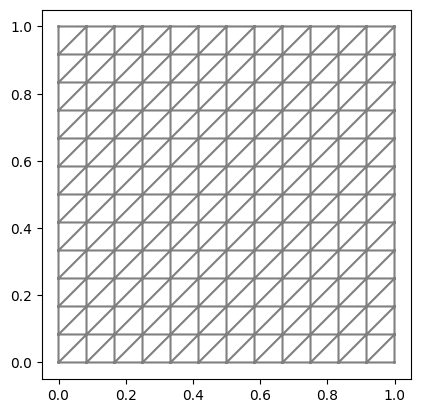

In [2]:
N_POINTS_P_AXIS = 12 # discretization points
FORCING_MAGNITUDE = 1.0 # external force

# Mesh and Finite Element Discretization
mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS)

plt.figure()
fe.plot(mesh)

## Defining the finite element function space
After the mesh, we define the finite element function space. We will use linear lagrangian finite elements (P1).

In [4]:
# Function space
lagrange_polynomial_space_first_order = fe.FunctionSpace(
    mesh,
    "Lagrange", # "CG" = Continuos Galerkin
    1
)

## Defining the boundary condition
Here boundary conditions are defined. For this problem, homogeneous Dirichlet boundary conditions are considered.

In [6]:
# The value of the solution on the boundary
u_on_boundary = fe.Constant(0.0)

# A function to return whether we are on the boundary
# for our case is simple, since we have only one type of boundary condition
def boundary_function(x, on_boundary):
    return on_boundary

# The homogeneous Dirichlet Boundary Condition
boundary_condition = fe.DirichletBC(
    lagrange_polynomial_space_first_order,
    u_on_boundary,
    boundary_function,
)

## Defining the variational problem
The finite element variational problem  reads: Find $u \in V$ such that
$$
\int_{\Omega} (\nabla u \cdot \nabla v) \,\mathrm{d}x = \int_{\Omega} fv \,\mathrm{d}x
$$
for all $v \in V$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \nabla u \cdot \nabla v \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} fv \,\mathrm{d}x.
\end{align}

To have, in the end, the following linear problem:
$$
a(u,v) = L(v)
$$

In [12]:
# Weak formulation
u_trial = fe.TrialFunction(lagrange_polynomial_space_first_order)
v_test = fe.TestFunction(lagrange_polynomial_space_first_order)

forcing = fe.Constant(- FORCING_MAGNITUDE)
a = fe.dot(fe.grad(u_trial), fe.grad(v_test)) * fe.dx
L = forcing * v_test * fe.dx

u_solution = fe.Function(lagrange_polynomial_space_first_order)

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` loop.

In [15]:
# Finite Element Assembly and Linear System solve
u_solution = fe.Function(lagrange_polynomial_space_first_order)
fe.solve(
    a == L,
    u_solution,
    boundary_condition,
)

## Visualization

Use the `plot` command to visualize the solution. 

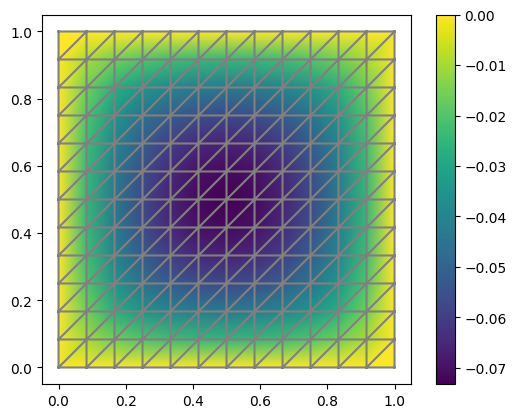

In [14]:
# Visualize
c = fe.plot(u_solution, mode="color")
plt.colorbar(c)
fe.plot(mesh)

plt.show()